In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import hashlib
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

In [ ]:
# The directory that contains all the base npz files 
base_dir = r"root of npz files from preprocessing" 
files = [f for f in os.listdir(base_dir) if f.endswith("_pairs.npz")]

Below is the function show_random_samples which is used to visualise samples of before/after and mask patches

In [47]:
# Three samples to include before after and include the black images to understand damage and no damage images
def show_random_samples(file_path, n_samples=3):
   
    # Load arrays from npz: before, after and masks
    data = np.load(file_path)
    before, after, masks = data["before"], data["after"], data["masks"]

    # Build an indice list of all patches
    all_indices = list(range(len(before)))
  
    # Pick from random sample of indices 
    chosen = random.sample(all_indices, min(n_samples, len(all_indices)))

    # loop through chosen samples
    for i in chosen:
        # Convert to RGB just for plotting as this makes it visible to human eye for EDA 
        bef_sam = np.transpose(before[i, :3], (1, 2, 0)).astype(float)
        aft_sam = np.transpose(after[i, :3], (1, 2, 0)).astype(float)
        mas_sam = masks[i]

        # Normalize to [0,1] safely
        bef_sam = bef_sam / bef_sam.max() if bef_sam.max() > 0 else bef_sam
        aft_sam = aft_sam / aft_sam.max() if aft_sam.max() > 0 else aft_sam

        # Plot before/after/mask visuals comparisons
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1); plt.imshow(bef_sam); plt.title("Before"); plt.axis("off")
        plt.subplot(1, 3, 2); plt.imshow(aft_sam); plt.title("After"); plt.axis("off")
        plt.subplot(1, 3, 3); plt.imshow(mas_sam, cmap="gray"); plt.title("Mask"); plt.axis("off")
        plt.suptitle(os.path.basename(file_path))
        plt.show()



Below is the function summarise_city_patches to view and summarise the data to be able to explore it

In [48]:
# Summarise all data for the patches in the pairs.npz files as they are seperate in each city
def summarise_city_patches(base_dir):
    
    # Two different data types are collected, per city stats and the grand total for all cities after
    
    rows = []  # holds per-city stats
    # Grand totals of all cities 
    total_damaged, total_nodamage, total_patches = 0, 0, 0
    total_black_before, total_black_after = 0, 0

    # loop through all files in directory to find the files needed
    for file in os.listdir(base_dir):
        
        if file.endswith("_pairs.npz"):
            city = file.replace("_pairs.npz", "")
            data = np.load(os.path.join(base_dir, file))
            X_before, X_after, masks = data["before"], data["after"], data["masks"]

            # Basic counts for before damaged
            total = X_before.shape[0]
            
            # Sum each mask and assign them to pixels per patch
            pixels_per_patch = masks.sum(axis=(1, 2))

            # A patch is assigned to is_damaged if it has at least one damaged pixel
            is_damaged = pixels_per_patch > 0

            # Count total number of how many patches are damaged
            damaged = int(is_damaged.sum())
            nodamage = total - damaged

            # Detect fully black patches in before/after as they should not be any
            # These collect the max pixels for each patch (before and after)
            max_before = X_before.max(axis=(1, 2, 3))  
            max_after  = X_after.max(axis=(1, 2, 3))  
            
            # If the amount of pixels of a patch is 0 it is black so this is assigned to before and after
            black_before = int((max_before == 0).sum())  
            black_after  = int((max_after == 0).sum())

            # Update totals
            total_patches += total
            total_damaged += damaged
            total_nodamage += nodamage
            total_black_before += black_before
            total_black_after  += black_after

            # Store per-city row of the totals 
            rows.append((city, total, damaged, nodamage,
                         round(damaged / total * 100, 1),
                         black_before, black_after))

            # call to show visual examples of each
            print(f"\n Showing samples from {city}")
            show_random_samples(os.path.join(base_dir, file), n_samples=1)

    # Build a dataFrame with all stats for all the cities
    combined_cities = pd.DataFrame(rows, columns=[
        "City", "Total Patches", "Damaged", "No-damage", "% Damaged",
        "Black Before", "Black After"
    ])

    # Print table of each cities stats
    print("\n====== Patch Summary ======")
    print(combined_cities.to_string(index=False))

    # Print grand totals across all cities
    print("\nGrand Totals:")
    print(f"  Total patches    : {total_patches}")
    print(f"  Damaged          : {total_damaged}")
    print(f"  No-damage        : {total_nodamage}")
    print(f"  % Damaged        : {round(total_damaged / total_patches * 100, 2)}%")
    print(f"  Black Before     : {total_black_before}")
    print(f"  Black After      : {total_black_after}")

    # Save to CSV in the same directory
    save_path = os.path.join(base_dir, "patch_summary.csv")
    combined_cities.to_csv(save_path, index=False)
    print(f"\nSummary saved to {save_path}")

    return combined_cities



 Showing samples from Antonivka


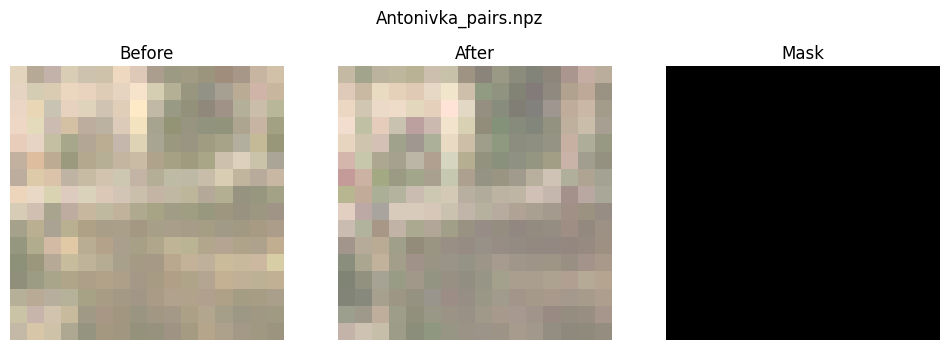


 Showing samples from Avdiivka


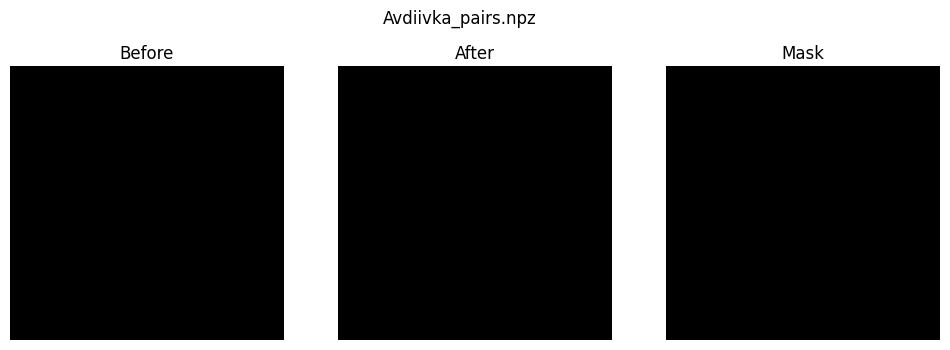


 Showing samples from Azovstal industrial


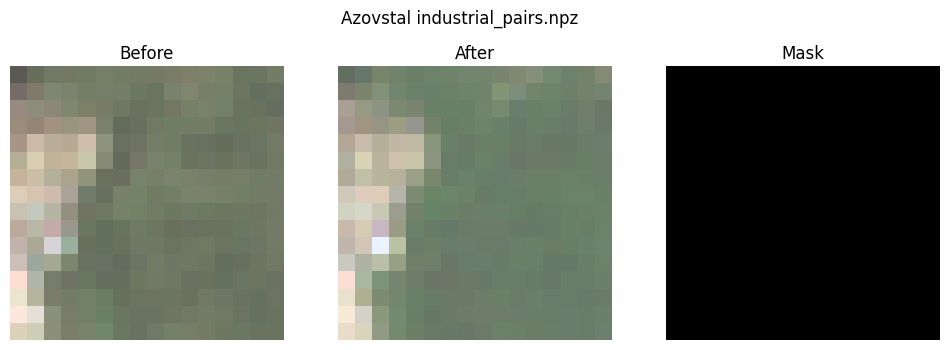


 Showing samples from Bucha


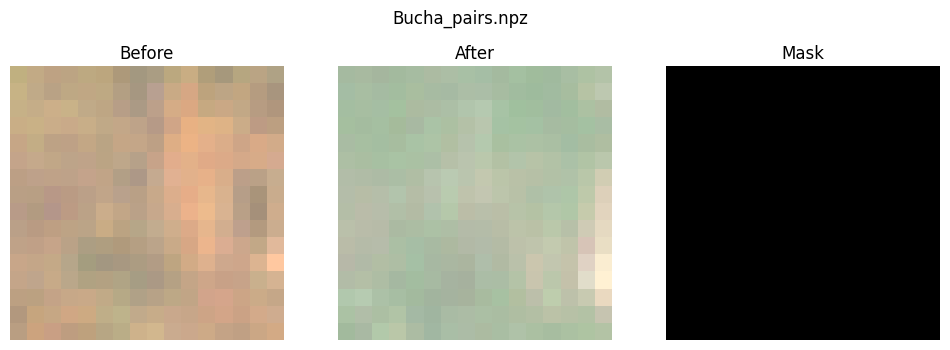


 Showing samples from Chernihiv


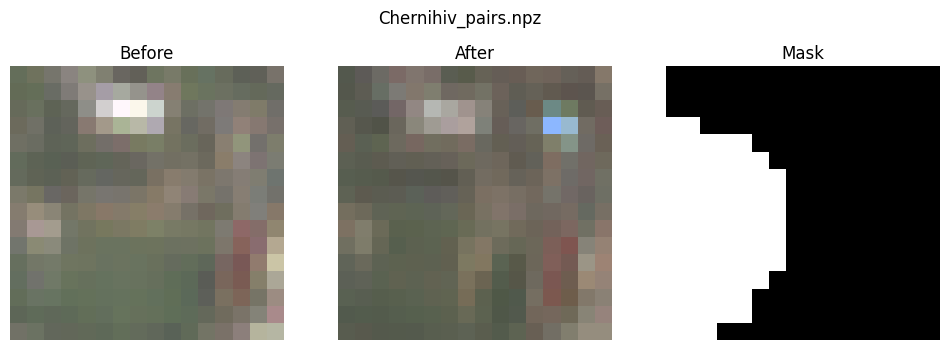


 Showing samples from Hostomel


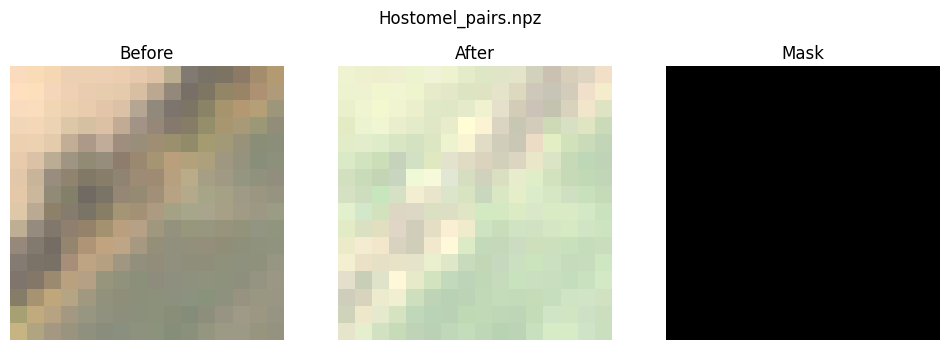


 Showing samples from Irpin


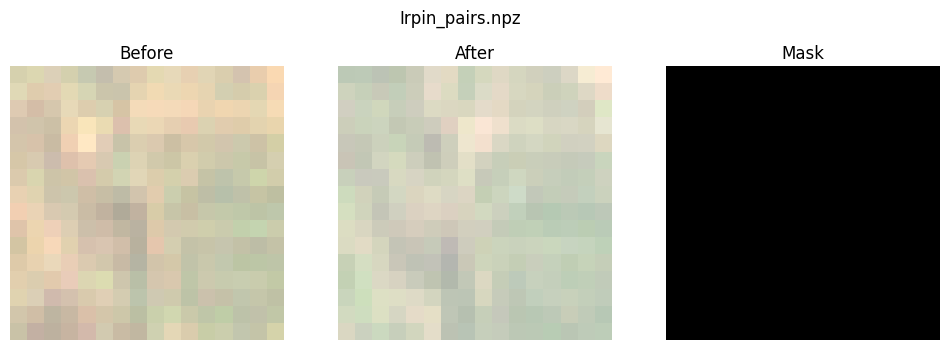


 Showing samples from Kharkiv


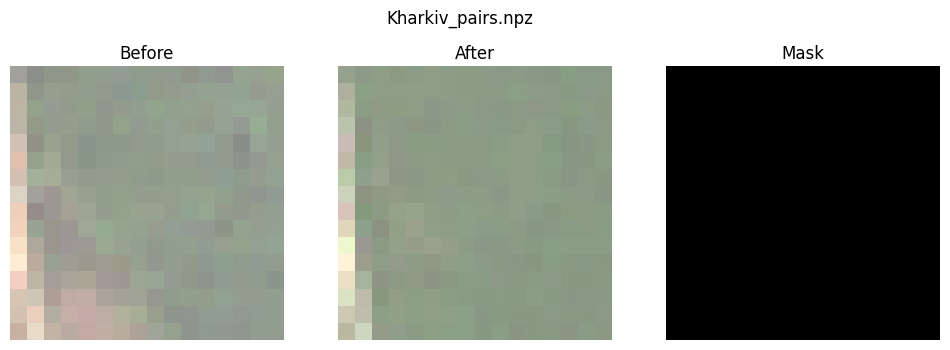


 Showing samples from Kherson


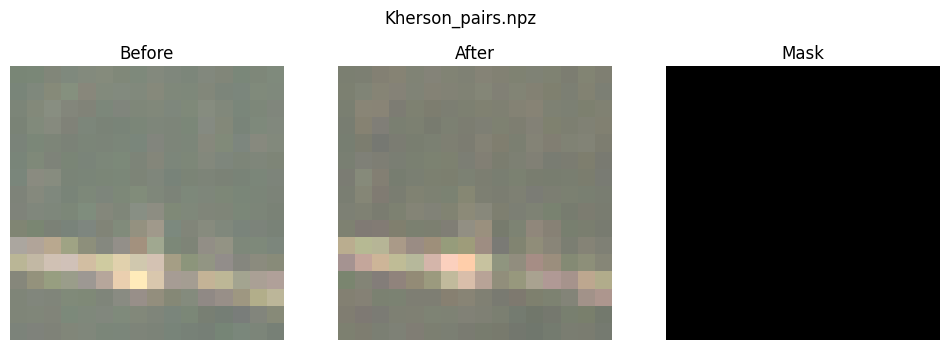


 Showing samples from Kramatorsk


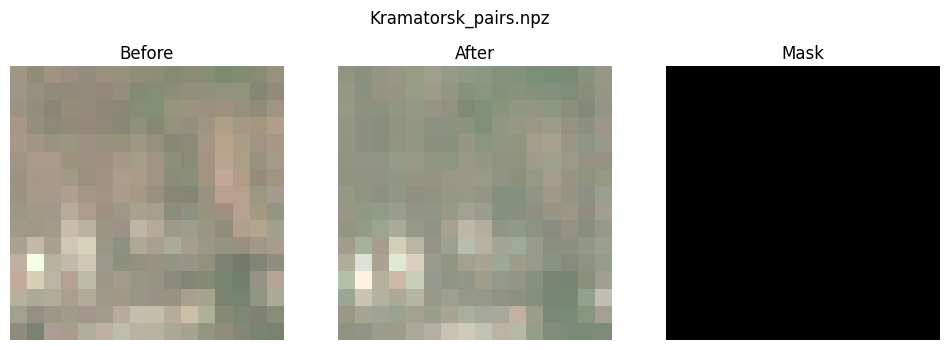


 Showing samples from Kremenchuk


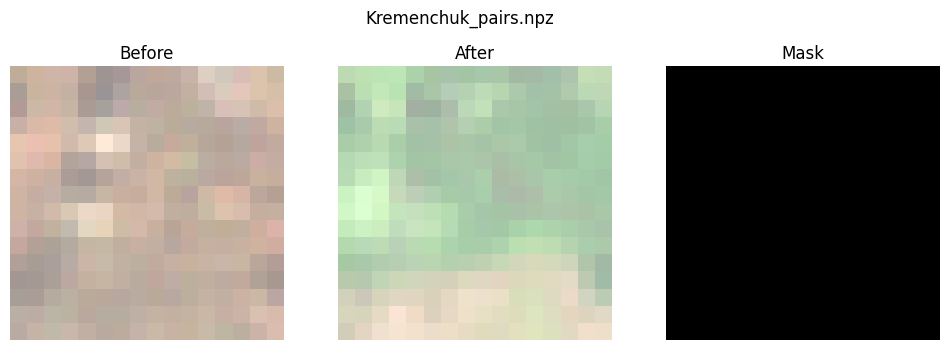


 Showing samples from Lysychansk


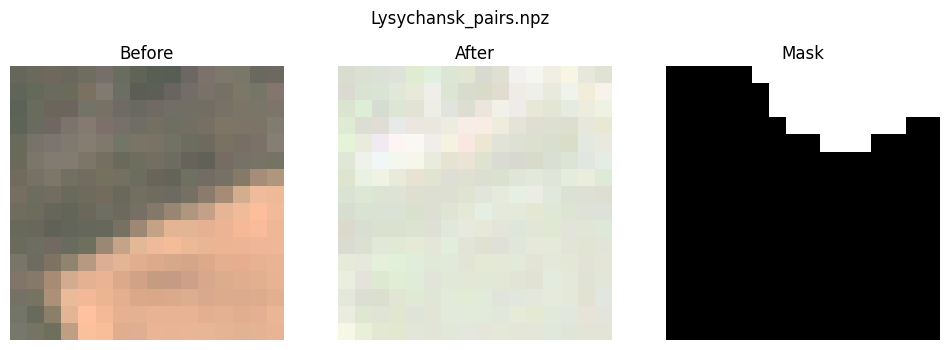


 Showing samples from Makariv


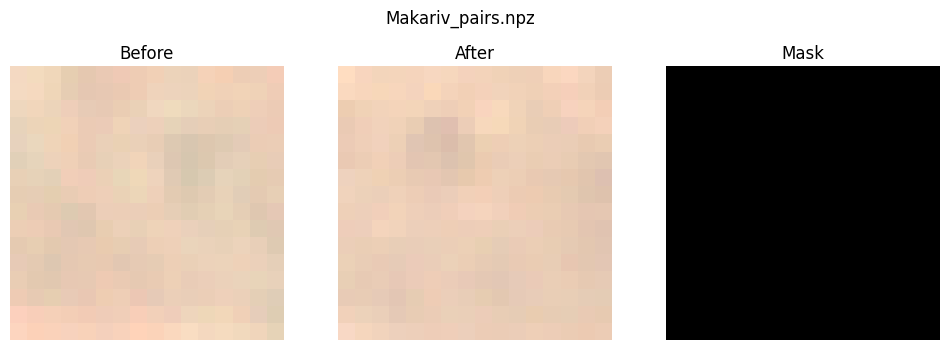


 Showing samples from Melitopol


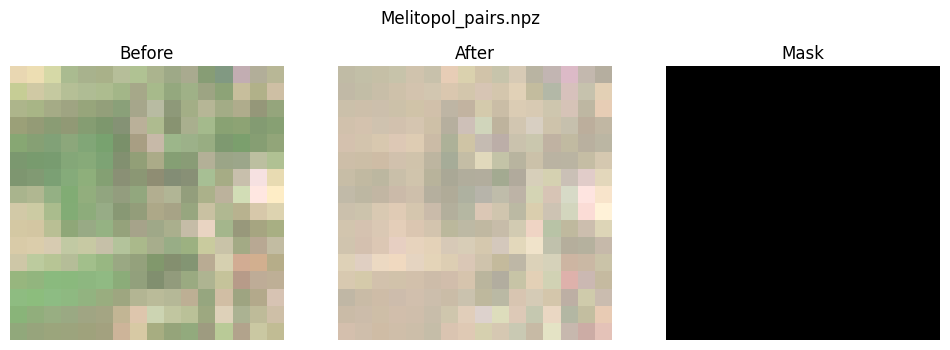


 Showing samples from Mykolaiv


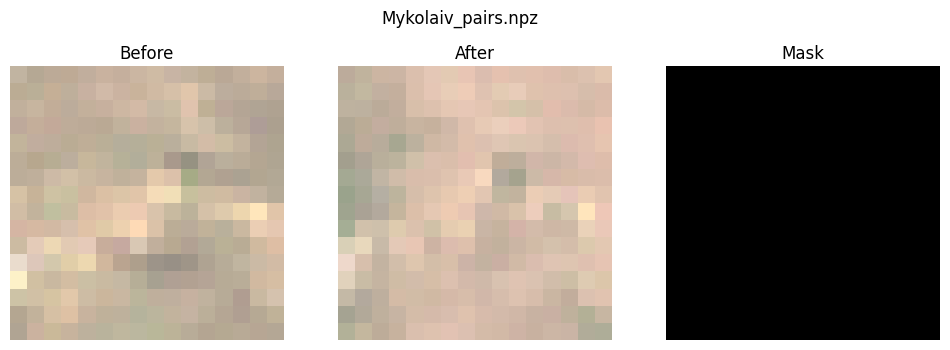


 Showing samples from Okhtyrka


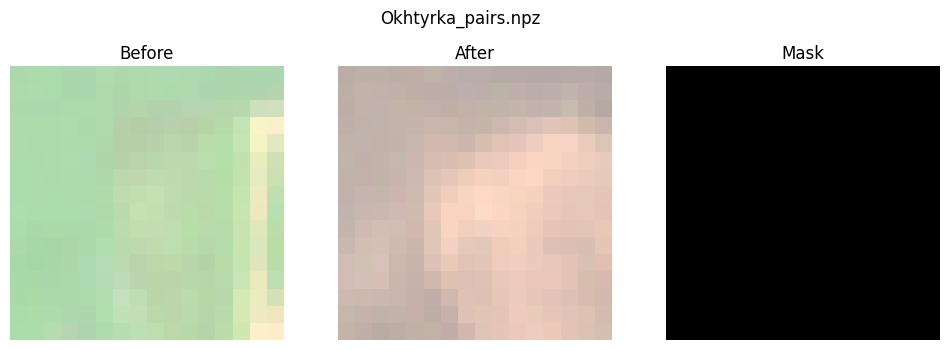


 Showing samples from Rubizhne


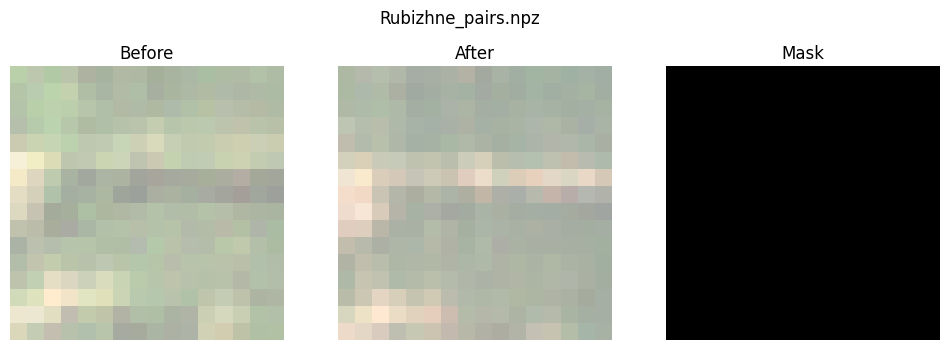


 Showing samples from Shchastia


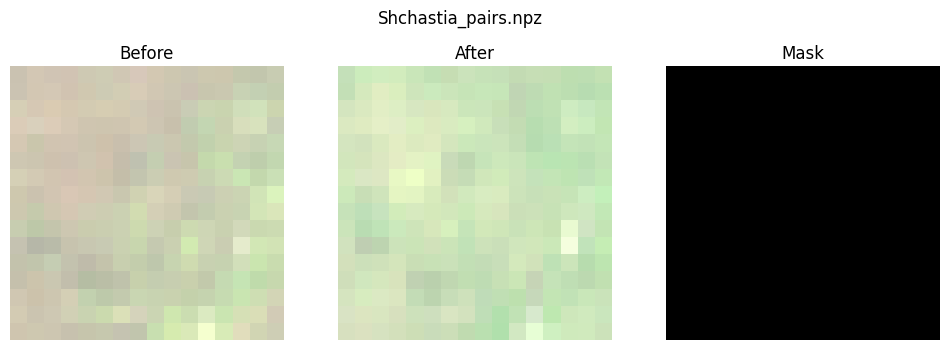


 Showing samples from Sumy


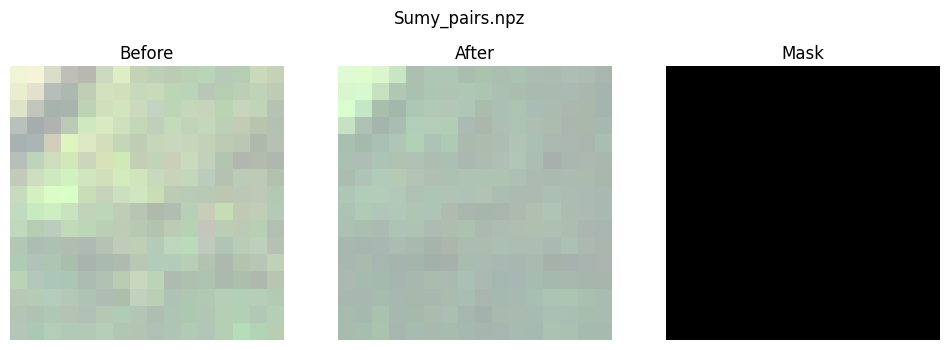


 Showing samples from Trostianets


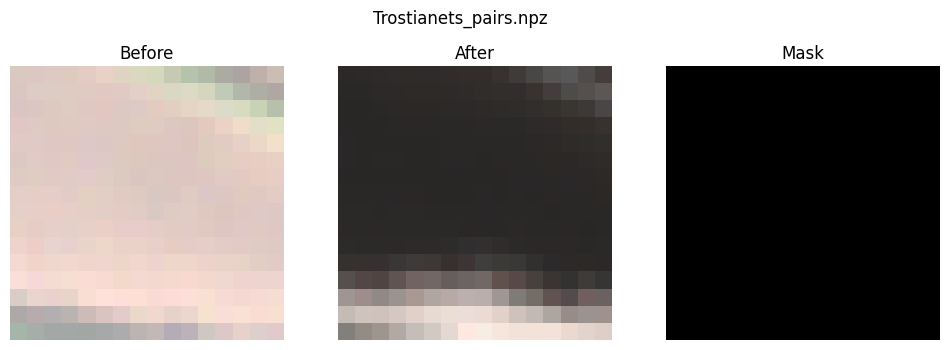


 Showing samples from Volnovakha


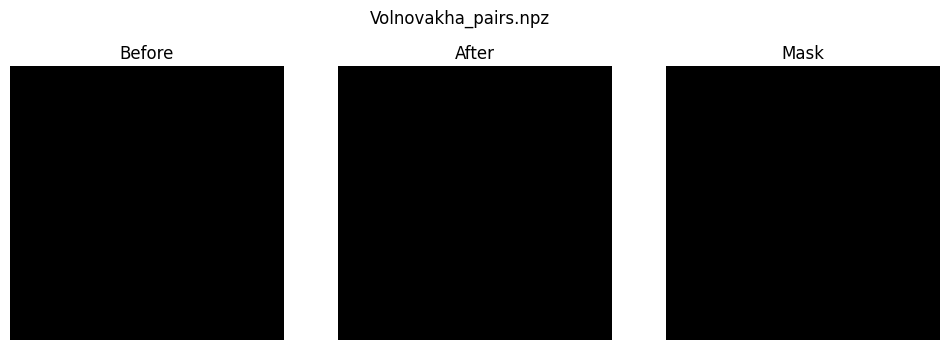


 Showing samples from Vorzel


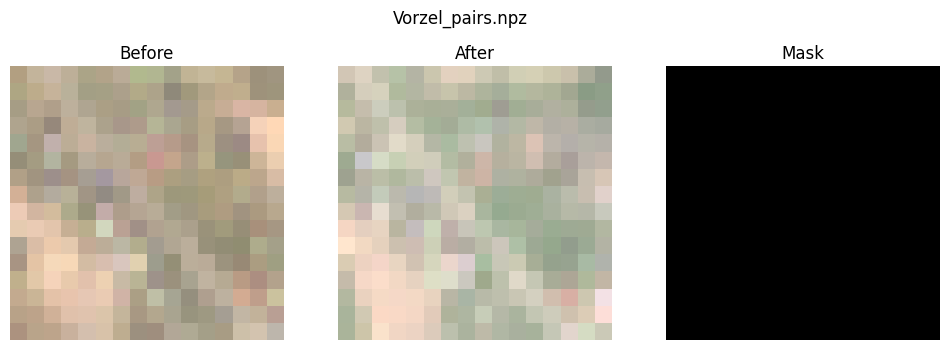


====== Patch Summary ======
               City  Total Patches  Damaged  No-damage  % Damaged  Black Before  Black After
          Antonivka           1019       19       1000        1.9           108          108
           Avdiivka           1137      137       1000       12.0           195          195
Azovstal industrial           1057       57       1000        5.4             0            0
              Bucha           1033       33       1000        3.2             0            0
          Chernihiv           1088       88       1000        8.1             0            0
           Hostomel           1058       58       1000        5.5             0            0
              Irpin           1097       97       1000        8.8            98           98
            Kharkiv           1088       88       1000        8.1           247          247
            Kherson           1014       14       1000        1.4           200          200
         Kramatorsk           1011       

In [49]:
# Run summary on all cities; also show example patches
combined_cities = summarise_city_patches(base_dir)


From visualising and the summary statistics, few things are evident, there are black patches in the before and after and there are far more no damage patches, first step is to remove the black patches from before and after.

In [50]:
# Function to remove all black patches 
def remove_black_patches(in_file):
    
    # Load the patches in again
    data = np.load(in_file)
    before, after, masks = data["before"], data["after"], data["masks"]

    # Find black patches again for removal
    black_before = (before.max(axis=(1, 2, 3)) == 0)
    black_after  = (after.max(axis=(1, 2, 3)) == 0)
    # Set them to be removed | is used as or, so if either has black remove
    to_remove = black_before | black_after

    # Keep only non-black patches and remove the rest
    keep_patch = np.where(~to_remove)[0]
    before_clean = before[keep_patch]
    after_clean  = after[keep_patch]
    masks_clean  = masks[keep_patch]

    # Save cleaned dataset
    np.savez_compressed(in_file, before=before_clean, after=after_clean, masks=masks_clean)

    removed = to_remove.sum()
    kept = len(keep_patch)
    print(f"Cleaned {os.path.basename(in_file)} → Kept {kept}, Removed {removed}")
    return kept, removed


In [51]:
for file in os.listdir(base_dir):
    if file.endswith("_pairs.npz"):
        remove_black_patches(os.path.join(base_dir, file))

Cleaned Antonivka_pairs.npz → Kept 911, Removed 108
Cleaned Avdiivka_pairs.npz → Kept 942, Removed 195
Cleaned Azovstal industrial_pairs.npz → Kept 1057, Removed 0
Cleaned Bucha_pairs.npz → Kept 1033, Removed 0
Cleaned Chernihiv_pairs.npz → Kept 1088, Removed 0
Cleaned Hostomel_pairs.npz → Kept 1058, Removed 0
Cleaned Irpin_pairs.npz → Kept 999, Removed 98
Cleaned Kharkiv_pairs.npz → Kept 841, Removed 247
Cleaned Kherson_pairs.npz → Kept 814, Removed 200
Cleaned Kramatorsk_pairs.npz → Kept 828, Removed 183
Cleaned Kremenchuk_pairs.npz → Kept 808, Removed 201
Cleaned Lysychansk_pairs.npz → Kept 1184, Removed 0
Cleaned Makariv_pairs.npz → Kept 918, Removed 132
Cleaned Melitopol_pairs.npz → Kept 976, Removed 52
Cleaned Mykolaiv_pairs.npz → Kept 704, Removed 313
Cleaned Okhtyrka_pairs.npz → Kept 1014, Removed 0
Cleaned Rubizhne_pairs.npz → Kept 868, Removed 209
Cleaned Shchastia_pairs.npz → Kept 534, Removed 479
Cleaned Sumy_pairs.npz → Kept 1009, Removed 0
Cleaned Trostianets_pairs.npz → 

Recheck that the removal of black patches has worked and quick overview of where the dataset is

In [52]:
def check_cleaned_patches(out_dir):
   
    total_patches, total_damaged, total_nodamage = 0, 0, 0
    black_before, black_after = 0, 0

    for file in os.listdir(out_dir):
        if file.endswith("_pairs.npz"):
            data = np.load(os.path.join(out_dir, file))
            before, after, masks = data["before"], data["after"], data["masks"]

            total = before.shape[0]
            
            # Count damaged vs no-damage patches
            pixels_per_patch = masks.sum(axis=(1, 2))
            is_damaged = pixels_per_patch > 0
            damaged = int(is_damaged.sum())
            nodamage = total - damaged

            # Check black patches, this should be zero after cleaning
            black_before += int((before.max(axis=(1,2,3)) == 0).sum())
            black_after  += int((after.max(axis=(1,2,3)) == 0).sum())

            total_patches += total
            total_damaged += damaged
            total_nodamage += nodamage

    print("\n====== Cleaned Dataset Summary ======")
    print(f" Total patches : {total_patches}")
    print(f" Damaged       : {total_damaged}")
    print(f" No-damage     : {total_nodamage}")
    print(f" Black Before  : {black_before}")
    print(f" Black After   : {black_after}")


In [53]:
# call second summary
check_cleaned_patches(base_dir)


====== Cleaned Dataset Summary ======
 Total patches : 20058
 Damaged       : 1087
 No-damage     : 18971
 Black Before  : 0
 Black After   : 0


Next step is to reduce the amount of No-damage patches and build one combined dataset for all cities

In [ ]:
# Cap for non damaged is set to 1500 as damaged is 1087
def make_global_dataset_with_nodamage_cap(base_dir, out_path, nodamage_cap=1500):

    all_before, all_after, all_masks = [], [], []
    
    # Collect all patches from all cities, to be merged into one dataset
    for file in os.listdir(base_dir):
        if file.endswith("_pairs.npz"):
            data = np.load(os.path.join(base_dir, file))
            all_before.append(data["before"])
            all_after.append(data["after"])
            all_masks.append(data["masks"])
    
    # Merge into one big dataset 
    all_before = np.concatenate(all_before, axis=0)
    all_after = np.concatenate(all_after, axis=0)
    all_masks = np.concatenate(all_masks, axis=0)

    # label the patches using the masks and if the masks contain any damage then set to 1, if they don't then set to 0
    labels = (all_masks.sum(axis=(1, 2)) > 0).astype(int)
    damaged_indices = np.where(labels == 1)[0]
    nodamage_indices = np.where(labels == 0)[0]

    print(f"Total before capping: {len(damaged_indices)} damaged, {len(nodamage_indices)} no-damage")

    # Randomly sample no-damage patches for the dataset, setting replace to false to ensure no duplicates
    # Use the nodamage_cap to set the number of patches to 1087
    if len(nodamage_indices) > nodamage_cap:
        chosen_nodamage = np.random.choice(nodamage_indices, nodamage_cap, replace=False)
    
    # Combine damaged + sampled no-damage
    chosen_indices = np.concatenate([damaged_indices, chosen_nodamage])
    np.random.shuffle(chosen_indices)

    # Keep only the selected patches
    X_before = all_before[chosen_indices]
    X_after = all_after[chosen_indices]
    Y_masks = all_masks[chosen_indices]

    # Save the final file
    np.savez_compressed(out_path, before=X_before, after=X_after, masks=Y_masks)
    print(f"✅ Saved dataset to {out_path}")
    print(f"Final dataset: {X_before.shape[0]} patches "
          f"({len(damaged_indices)} damaged, {len(chosen_nodamage)} no-damage)")

# Run
out_path = os.path.join(base_dir, "GlobalNoDamageCapped_pairs.npz")
make_global_dataset_with_nodamage_cap(base_dir, out_path, nodamage_cap=1500)


The next step is to increase the damaged patches to 4000 to make it balanced. This is done by augmenting the damaged patches which also makes the model more robust by introudcing noise.

In [ ]:
def augment_to_target(in_path, out_path, target_damaged=1500):
   # Load dataset
    data = np.load(in_path)
    before, after, masks = data["before"], data["after"], data["masks"]

    # Labels
    labels = (masks.sum(axis=(1, 2)) > 0).astype(int)
    damaged_indices = np.where(labels == 1)[0]
    nodamage_indices = np.where(labels == 0)[0]

    num_damaged = len(damaged_indices)
    print(f"Existing damaged: {num_damaged}, target: {target_damaged}")

    # How many augmentations needed to be generated to achieve 4000 damage tiles
    needed = target_damaged - num_damaged

    # Select random damaged patches to augment, with replace on so some may be reused
    chosen = np.random.choice(damaged_indices, needed, replace=True)
    
    # Augmentations applied on all three together to keep it consistent and aligned
    aug_before, aug_after, aug_masks = [], [], []
    for i in chosen:
        bef, aft, mask = before[i], after[i], masks[i]

        # Simple augmentation: random flip horizontal/vertical or rotation
        aug_type = np.random.choice(["flip_h", "flip_v", "rot90"])
        if aug_type == "flip_h":
            bef, aft, mask = np.flip(bef, axis=2), np.flip(aft, axis=2), np.flip(mask, axis=1)
        elif aug_type == "flip_v":
            bef, aft, mask = np.flip(bef, axis=1), np.flip(aft, axis=1), np.flip(mask, axis=0)
        elif aug_type == "rot90":
            k = np.random.randint(1, 4)  # rotate 90, 180, 270
            bef, aft, mask = np.rot90(bef, k, axes=(1, 2)), np.rot90(aft, k, axes=(1, 2)), np.rot90(mask, k)

        aug_before.append(bef)
        aug_after.append(aft)
        aug_masks.append(mask)

    # Merge the augmented tiles to original data 
    X_before = np.concatenate([before, np.stack(aug_before)])
    X_after = np.concatenate([after, np.stack(aug_after)])
    Y_masks = np.concatenate([masks, np.stack(aug_masks)])

    # Shuffle the dataset so the augmented tiles are mixed in and not at the end
    indices = np.arange(len(X_before))
    np.random.shuffle(indices)

    X_before, X_after, Y_masks = X_before[indices], X_after[indices], Y_masks[indices]

    # Save final dataset
    np.savez_compressed(out_path, before=X_before, after=X_after, masks=Y_masks)
    print(f"✅ Saved augmented dataset to {out_path}")
    print(f"Final count: {len(Y_masks)} patches "
          f"({target_damaged} damaged, {len(nodamage_indices)} no-damage)")

in_path = r"\GlobalNoDamageCapped_pairs.npz"
out_path = r"\GlobalBalancedAugmented_pairs.npz"

augment_to_target(in_path, out_path, target_damaged=1500)


Next the data is checked for dupilcates, as there could be a instances of the augmentation being random or the dataset being built. 

🔍 Found 21 duplicate pairs


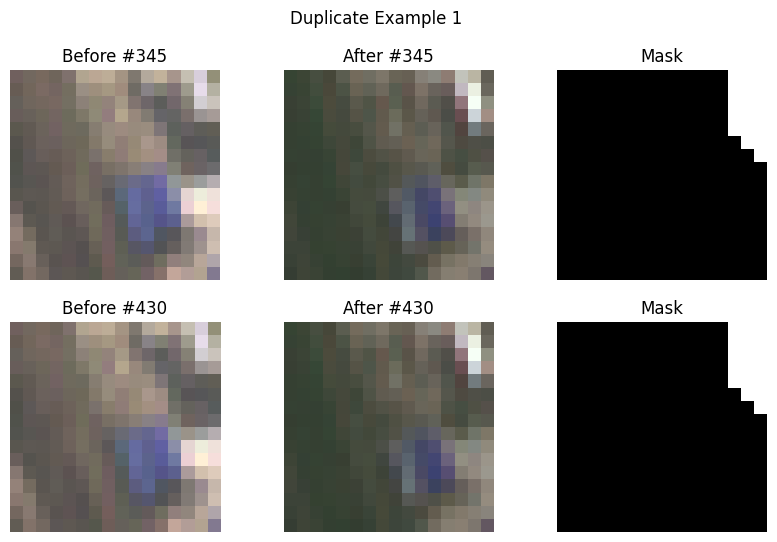

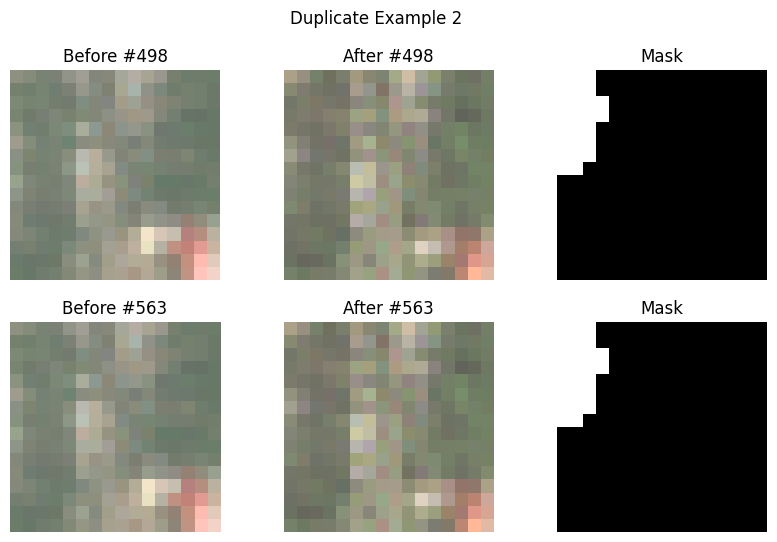

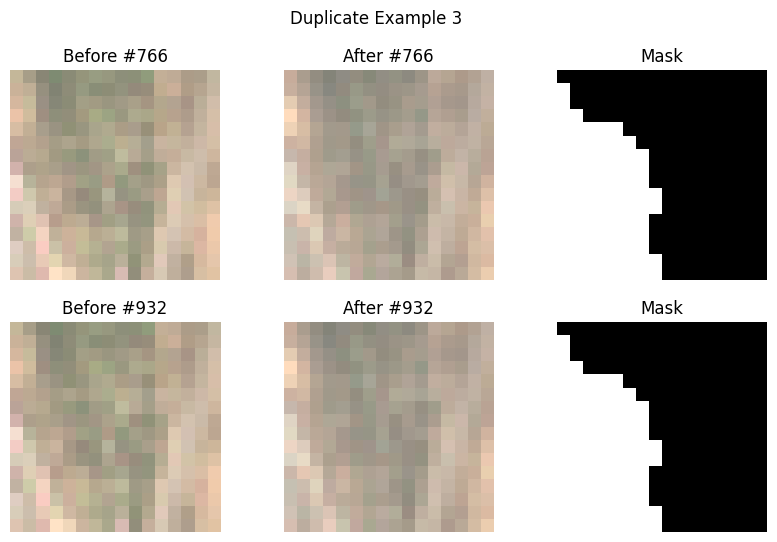

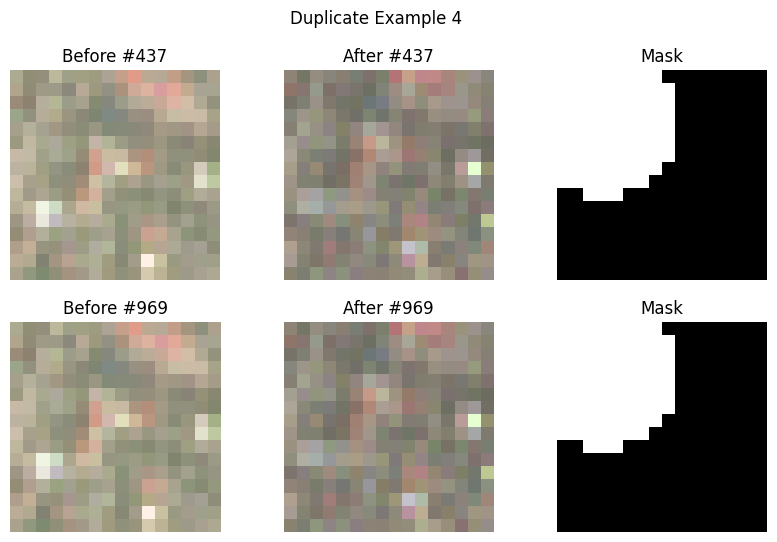

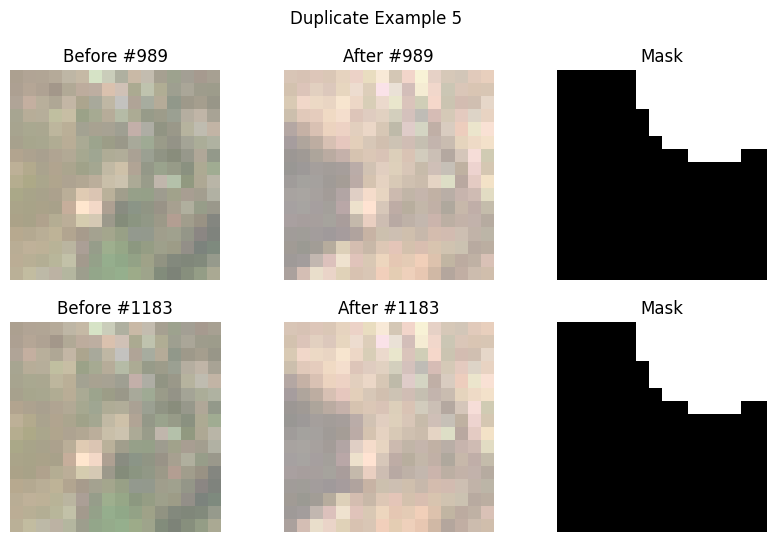

In [ ]:
# This will find duplicates and print 5 examples for visual comparison
def show_duplicate_examples(npz_path, max_examples=5):
    data = np.load(npz_path)
    before, after, masks = data["before"], data["after"], data["masks"]
    
    # build list of seen and dupes, so if seen matches twice then it goes into dupes
    seen = {}
    dupes = []

    for i in range(before.shape[0]):
        # flatten (ravel) the before, after, and mask arrays for patch i and concate into triplets so they can be compared for duplicates
        triplet = np.concatenate([before[i].ravel(),
                                  after[i].ravel(),
                                  masks[i].ravel()])
        
        # Create a SHA-1 hash of the triplet so that it is more efficent than using large arrays
        h = hashlib.sha1(triplet).hexdigest()
        if h in seen:
            dupes.append((seen[h], i))  
        else:
            seen[h] = i

    print(f"🔍 Found {len(dupes)} duplicate pairs")

    # Visualise the 5 examples to make sure they are actually duplicates
    for idx, (i1, i2) in enumerate(dupes[:max_examples]):
        b1, a1, m1 = before[i1], after[i1], masks[i1]
        b2, a2, m2 = before[i2], after[i2], masks[i2]

        def prep(img):  # normalise RGB for visualisation
            rgb = np.transpose(img[:3], (1, 2, 0)).astype(float)
            return rgb / rgb.max() if rgb.max() > 0 else rgb

        plt.figure(figsize=(10,6))
        plt.subplot(2,3,1); plt.imshow(prep(b1)); plt.title(f"Before #{i1}"); plt.axis("off")
        plt.subplot(2,3,2); plt.imshow(prep(a1)); plt.title(f"After #{i1}"); plt.axis("off")
        plt.subplot(2,3,3); plt.imshow(m1, cmap="gray"); plt.title("Mask"); plt.axis("off")

        plt.subplot(2,3,4); plt.imshow(prep(b2)); plt.title(f"Before #{i2}"); plt.axis("off")
        plt.subplot(2,3,5); plt.imshow(prep(a2)); plt.title(f"After #{i2}"); plt.axis("off")
        plt.subplot(2,3,6); plt.imshow(m2, cmap="gray"); plt.title("Mask"); plt.axis("off")

        plt.suptitle(f"Duplicate Example {idx+1}")
        plt.show()


show_duplicate_examples(
    r"GlobalBalancedAugmented_pairs.npz",
    max_examples=5
)


Next step would be to remove those duplicates

In [ ]:
def remove_duplicates(npz_path):
   
    data = np.load(npz_path)
    before, after, masks = data["before"], data["after"], data["masks"]

    # Similar logic as before but store the ones that arent seen
    seen = set()
    keep_indices = []

    
    for i in range(before.shape[0]):
        triplet = np.concatenate([
            before[i].ravel(),
            after[i].ravel(),
            masks[i].ravel()
        ])
        h = hashlib.sha1(triplet).hexdigest()
        
        # Keep the new triplets if not seen then add to seen and keep indices
        if h not in seen:
            seen.add(h)
            keep_indices.append(i)

    # Filter arrays
    before_clean = before[keep_indices]
    after_clean = after[keep_indices]
    masks_clean = masks[keep_indices]

    # Save cleaned dataset without the duplicates
    
    base, ext = os.path.splitext(npz_path)
    out_path = base + "_cleaned" + ext

    np.savez_compressed(out_path,before=before_clean, after=after_clean, masks=masks_clean)

    removed = before.shape[0] - len(keep_indices)
    print(f"✅ Saved cleaned dataset to {out_path}")
    print(f"   Kept {len(keep_indices)} patches, removed {removed} duplicates")

    return len(keep_indices), removed

remove_duplicates(
    r"GlobalBalancedAugmented_pairs.npz"
)


Now the dataset is summerised again to see if it needs balancing

In [ ]:
def summarise_dataset(npz_path):
    
    data = np.load(npz_path)
    before, after, masks = data["before"], data["after"], data["masks"]

    total = before.shape[0]
    damaged = int((masks.sum(axis=(1, 2)) > 0).sum())
    nodamage = total - damaged

    # Check for any all-black patches (before or after)
    black_before = int((before.max(axis=(1,2,3)) == 0).sum())
    black_after  = int((after.max(axis=(1,2,3)) == 0).sum())

    print("\n====== Dataset Summary ======")
    print(f" File          : {npz_path}")
    print(f" Total patches : {total}")
    print(f" Damaged       : {damaged}")
    print(f" No-damage     : {nodamage}")
    print(f" % Damaged     : {round(damaged/total * 100, 2)}%")
    print(f" Black Before  : {black_before}")
    print(f" Black After   : {black_after}")

    return {
        "file": npz_path,
        "total": total,
        "damaged": damaged,
        "nodamage": nodamage,
        "% damaged": round(damaged/total * 100, 2),
        "black_before": black_before,
        "black_after": black_after
    }
summarise_dataset(
    r"GlobalBalancedAugmented_pairs_cleaned.npz"
)


Next the dataset is balanced by removing the no damaged to make it equal to damaged

In [ ]:
def make_final_balanced_dataset(npz_path, out_path):
    data = np.load(npz_path)
    before, after, masks = data["before"], data["after"], data["masks"]

    # Identify damaged vs no-damage so the lengths can then be counted
    labels = (masks.sum(axis=(1,2)) > 0).astype(int)
    damaged_indices = np.where(labels == 1)[0]
    nodamage_indices = np.where(labels == 0)[0]

    n_damaged = len(damaged_indices)
    n_nodamage = len(nodamage_indices)

    print(f"Before balancing: Damaged={n_damaged}, No-damage={n_nodamage}")

    # randomly select a subset of no-damaged patches and make it match the amount of damaged
    np.random.shuffle(nodamage_indices)
    nodamage_indices = nodamage_indices[:n_damaged]

    final_indices = np.concatenate([damaged_indices, nodamage_indices])
    np.random.shuffle(final_indices)

    # Subset arrays
    before_final = before[final_indices]
    after_final = after[final_indices]
    masks_final = masks[final_indices]

    # Save
    np.savez_compressed(out_path,
                        before=before_final,
                        after=after_final,
                        masks=masks_final)

    # Final summary
    print(f"\n✅ Final dataset saved to {out_path}")
    print("====== Final Dataset Summary ======")
    print(f"  Damaged   : {n_damaged}")
    print(f"  No-damage : {n_damaged}")
    print(f"  Total     : {2*n_damaged}")

make_final_balanced_dataset(
    r"GlobalBalancedAugmented_pairs_cleaned.npz",
    r"FinalBalanced_pairs.npz"
)


Now the damage distribution in the dataset per patch is plotted in a barchart to understand how strong the signal is for damage

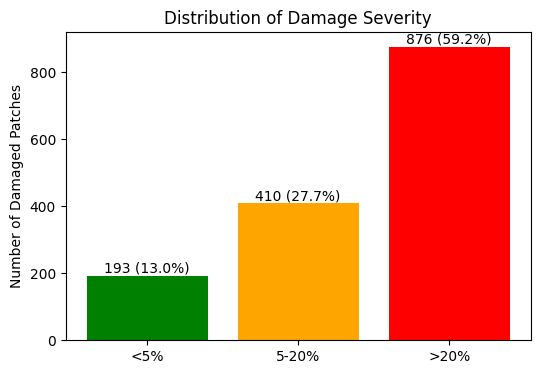

In [ ]:
def plot_damage_groups(npz_path):
    data = np.load(npz_path)
    masks = data["masks"]

    # Calculate the fraction of damaged pixels in each patch
    # Sum of mask values / total number of pixels in patch
    fractions = masks.sum(axis=(1, 2)) / (masks.shape[1] * masks.shape[2])

    # Remove all patches with no damage so focus only on damaged
    fractions = fractions[fractions > 0]

    # Grouping patches into distribution of damage severity
    groups = {
        "<5%": (fractions < 0.05).sum(),
        "5-20%": ((fractions >= 0.05) & (fractions < 0.2)).sum(),
        ">20%": (fractions >= 0.2).sum()
    }

    # Plot bar charts to compare them
    plt.figure(figsize=(6,4))
    bars = plt.bar(groups.keys(), groups.values(), color=["green", "orange", "red"])
    plt.ylabel("Number of Damaged Patches")
    plt.title("Distribution of Damage Severity")

    # Add labels on top of bars for how many in each category
    total = fractions.shape[0]
    for bar, label in zip(bars, groups.values()):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height, 
                 f"{label} ({label/total:.1%})", ha="center", va="bottom")

    plt.show()

    
plot_damage_groups(
    r"FinalBalanced_pairs.npz"
)



This means that there will be difficulty in detecting damage because the change from before to after will be minimal for most damaged patches.
Then PCA is conducted to if there are any possible patterns emerging, so the first step is to see what explains 80 variance

80% variance reached at 13 components (explained variance = 0.8006)


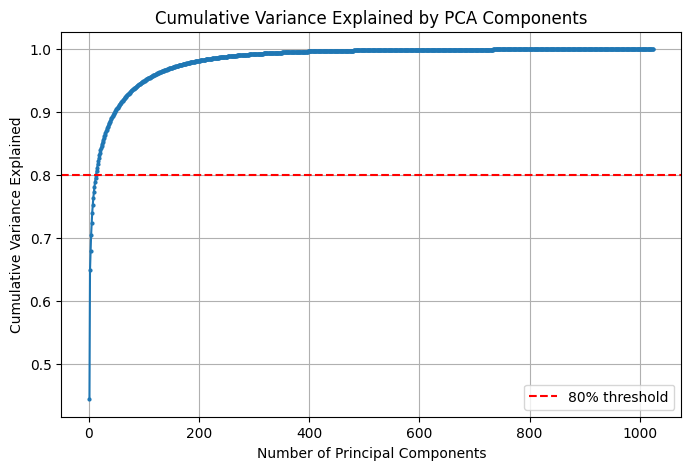

In [ ]:
def reduce_to_80_variance(npz_path, out_path):
    # Load dataset
    data = np.load(npz_path)
    after, masks = data["after"], data["masks"]

    # Flatten after-images into (N, features) so that PCA can be conducted
    after_flat = after.reshape(after.shape[0], -1)

    # Run full PCA on the dataset to calculate explained variance
    pca_full = PCA()
    pca_full.fit(after_flat)

    # Cumulative variance explained
    explained = np.cumsum(pca_full.explained_variance_ratio_)

    # Find number of components for 80% variance
    n_components_80 = np.argmax(explained >= 0.80) + 1
    variance_80 = explained[n_components_80 - 1]

    print(f"80% variance reached at {n_components_80} components "
          f"(explained variance = {variance_80:.4f})")

    # Plot cumulative variance
    plt.figure(figsize=(8,5))
    plt.plot(np.arange(1, len(explained)+1), explained, marker='o', markersize=2)
    plt.axhline(0.8, color='r', linestyle='--', label="80% threshold")
    plt.title("Cumulative Variance Explained by PCA Components")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Variance Explained")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Now fit PCA with optimal number of components (80%)
    pca_80 = PCA(n_components=n_components_80)
    after_reduced = pca_80.fit_transform(after_flat)

    # Save reduced dataset at 80% variance 
    np.savez_compressed(out_path, after_pca=after_reduced, masks=masks)

reduce_to_80_variance(
    r"root for final balanced",
    r"FinalBalanced_pca80.npz"
)


Now with the threshold perform k-means clustering, the threshold is used to explore the dataset to see if any visible patterns

Silhouette Score: 0.2404


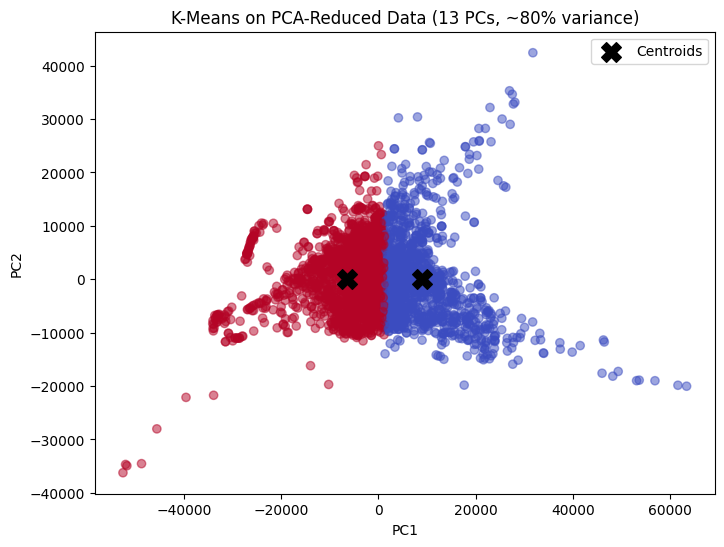

In [ ]:
def kmeans_on_pca(npz_path, n_clusters=2):
    # Load reduced dataset 
    data = np.load(npz_path)
    X = data["after_pca"]
    y = (data["masks"].sum(axis=(1,2)) > 0).astype(int)  # true labels (not used in clustering)

    # Run K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(X)

    # Compute silhouette score
    score = silhouette_score(X, clusters)
    print(f"Silhouette Score: {score:.4f}")

    # Visualise using just the first 2 PCs (for human interpretation)
    plt.figure(figsize=(8,6))
    plt.scatter(X[:,0], X[:,1], c=clusters, cmap="coolwarm", alpha=0.5)
    plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
                c="black", marker="X", s=200, label="Centroids")
    plt.title(f"K-Means on PCA-Reduced Data ({X.shape[1]} PCs, ~80% variance)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.show()

    return clusters, y, score

clusters, y, score = kmeans_on_pca(
    r"root for PCA"
)


Silhouette score of 0.1904 shows theres very minimal emerging patterns and the clusters are split straight down the middle and not in any way that shows a pattern when visualised. So this means that deep learning techniques are necessary.

Next step is to create the splits

In [63]:
# Load full balanced dataset
data = np.load("FinalBalanced_pairs.npz")
X_before, X_after, masks = data["before"], data["after"], data["masks"]

# X_before = patches from pre damage images
# X_after  = patches from post damage images
# y = labels (1 = damage, 0 = no-damage) from the masks

# Convert into binary Labels: 1 = damage, 0 = no-damage
y = (masks.sum(axis=(1, 2)) > 0).astype(np.int64)

# Define the split into 60 training 20 test 20 validation 
TEST_FRAC = 0.20
VAL_FRAC  = 0.20

# Adjustment so that the validation is exaclty 20 percent after taking 20 percent for test, then validation will be 25% of 80%
VAL_IN_TRAINVAL = VAL_FRAC / (1.0 - TEST_FRAC)  # 0.20 / 0.80 = 0.25

# 1) Hold out 20% for TEST
# Xb = "before" image patches
# Xa = "after" image patches
# y = labels
Xb_tv, Xb_test, Xa_tv, Xa_test, y_tv, y_test = train_test_split(
    X_before, X_after, y, test_size=TEST_FRAC, stratify=y
)

# 2) From remaining 80%, take 25% for VAL  -> 0.80 * 0.25 = 0.20 total
Xb_train, Xb_val, Xa_train, Xa_val, y_train, y_val = train_test_split(
    Xb_tv, Xa_tv, y_tv, test_size=VAL_IN_TRAINVAL, stratify=y_tv
)

# Quick summary the splits
def summarize(name, Xb, Xa, yy):
    n = len(yy)
    pos = int(yy.sum())
    neg = n - pos
    print(f"{name:6} n={n:<5} pos={pos:<4} neg={neg:<4} pos_rate={pos/n:.3f}  "
          f"Xb:{Xb.shape} Xa:{Xa.shape}")

summarize("train", Xb_train, Xa_train, y_train)
summarize("val",   Xb_val,   Xa_val,   y_val)
summarize("test",  Xb_test,  Xa_test,  y_test)

# sanity checks to make sure splits add up correctly and shapes align
N = len(y)
assert len(y_train) + len(y_val) + len(y_test) == N
assert Xb_train.shape[0] == Xa_train.shape[0] == len(y_train)
assert Xb_val.shape[0]   == Xa_val.shape[0]   == len(y_val)
assert Xb_test.shape[0]  == Xa_test.shape[0]  == len(y_test)

# Save splits to be used for the model
np.savez_compressed(
    "FinalBalanced_splits.npz",
    Xb_train=Xb_train, Xa_train=Xa_train, y_train=y_train,
    Xb_val=Xb_val,     Xa_val=Xa_val,     y_val=y_val,
    Xb_test=Xb_test,   Xa_test=Xa_test,   y_test=y_test,
)
print("Saved dataset splits to FinalBalanced_splits.npz")



train  n=1774  pos=887  neg=887  pos_rate=0.500  Xb:(1774, 4, 16, 16) Xa:(1774, 4, 16, 16)
val    n=592   pos=296  neg=296  pos_rate=0.500  Xb:(592, 4, 16, 16) Xa:(592, 4, 16, 16)
test   n=592   pos=296  neg=296  pos_rate=0.500  Xb:(592, 4, 16, 16) Xa:(592, 4, 16, 16)
Saved dataset splits to FinalBalanced_splits.npz
